<a href="https://colab.research.google.com/github/innosoft21/workspace/blob/main/tensorflow_R/UK_King_dead_timeseries_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

영국왕들의 사망나이 시계열 분석, 예측, ARIMA모형




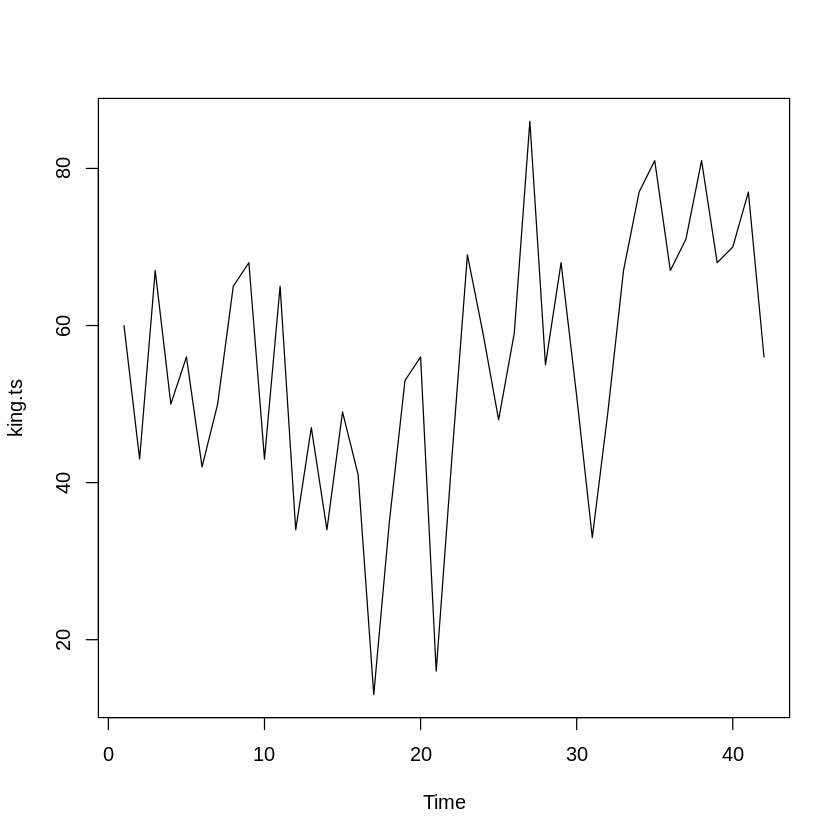

In [21]:
library(TTR)
library(forecast)
library(tseries)
king <- scan("http://robjhyndman.com/tsdldata/misc/kings.dat",skip=3)
king.ts <- ts(king)
plot(king.ts)

그래프보면 비정상성 시계열임.

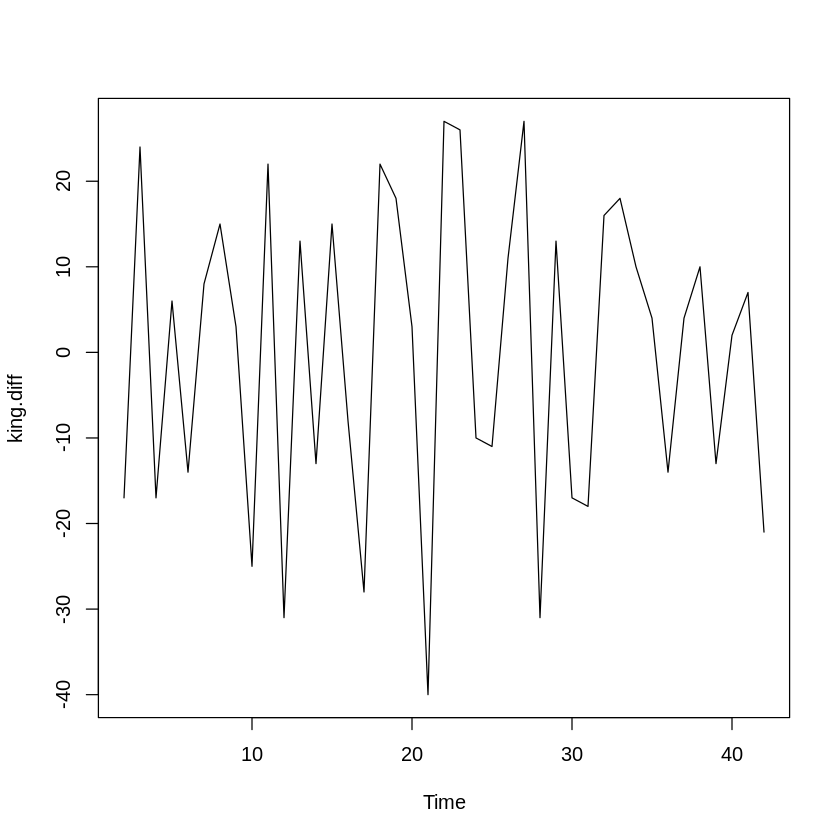

In [23]:
king.diff <- diff(king.ts, difference=1)
plot(king.diff)

ARIMA(p,1,q) 모델이며, 차분을 1회 해야 정상성을 만족한다.

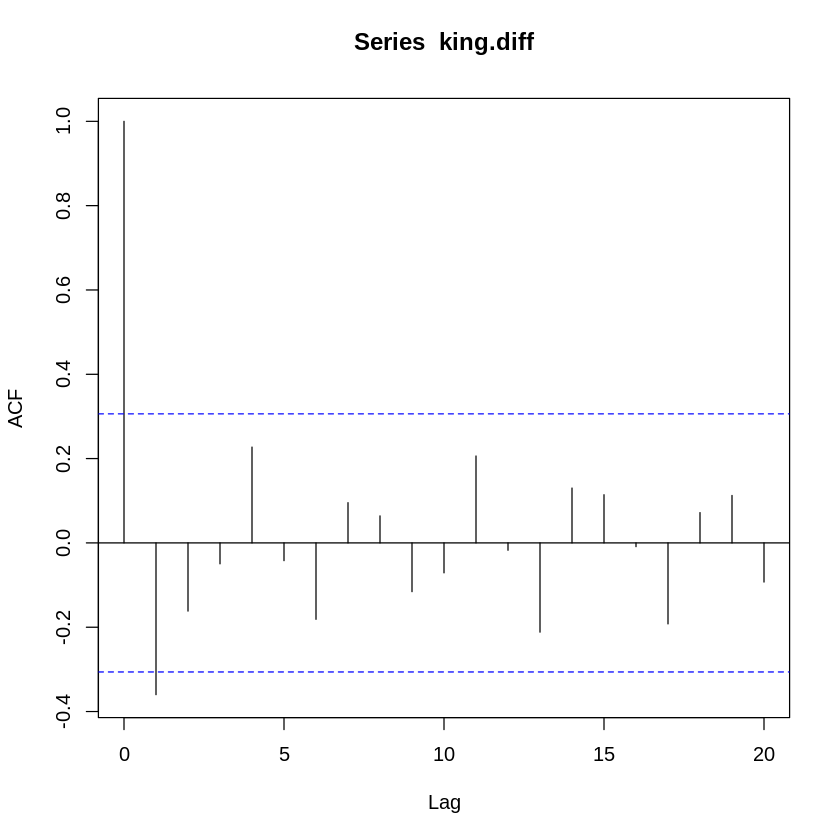

In [24]:
acf(king.diff, lag.max=20)

① ACF

lag는 0부터 값을 갖는데, 너무 많은 구간을 설정하면 그래프 판단이 어려우니 20으로 설정해준다.

ACF값이 lag1인 지점을 제외하고 모두 점선 구간 안에 있으므로, lag2에서 절단점을 가진다. => MA(1) 모형

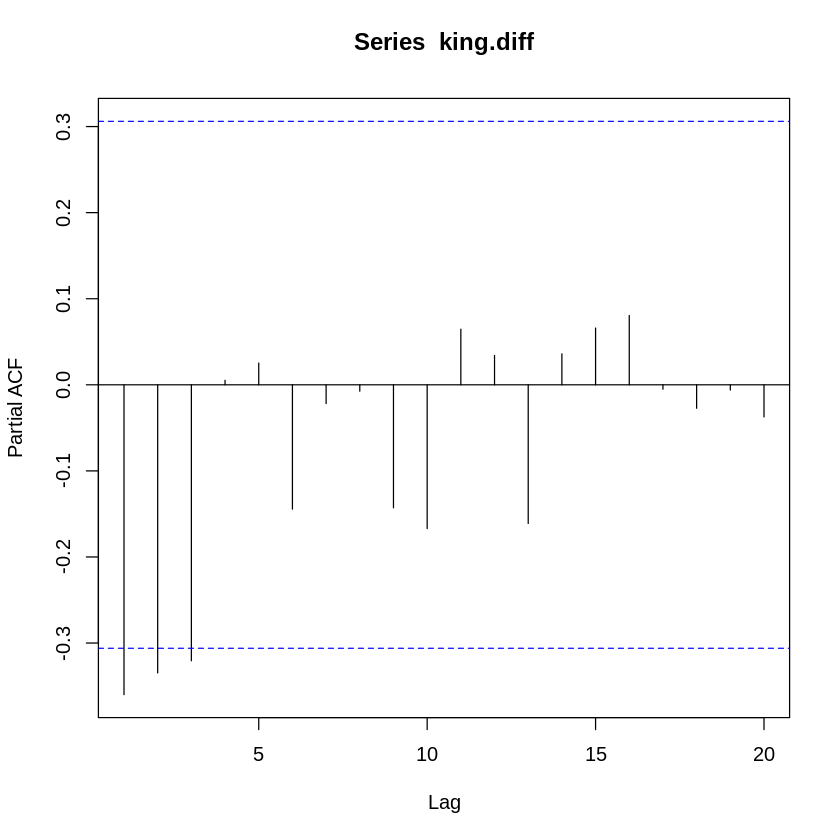

In [25]:
pacf(king.diff, lag.max=20)

② PACF

PACF값이 lag 1, 2, 3에서 점선 구간을 초과하고 음의 값을 가지며, 절단점은 lag 4이다. => AR(3) 모형

In [26]:
auto.arima(king)

Series: king 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.7218
s.e.   0.1208

sigma^2 estimated as 236.2:  log likelihood=-170.06
AIC=344.13   AICc=344.44   BIC=347.56

③ auto.arima

forecast package에 내장된 auto.arima() 함수 이용
영국 왕들의 사망 나이 데이터의 적절한 ARIMA 모델은 ARIMA(0,1,1) 이다.

결과적으로, 초기 분석에 의해 생성된 ARIMA 모델 후보들은 아래의 3가지이다.

AR(3) => ARIMA(3,1,0) 
MA(1) => ARIMA(0,1,1)  *auto.arima()로 생성된 모델과 동일.
ARMA(3,1) => ARIMA(3,1,1)

In [28]:
Arima(king.ts, order=c(3,1,0))

Series: king.ts 
ARIMA(3,1,0) 

Coefficients:
          ar1      ar2      ar3
      -0.6063  -0.4904  -0.3284
s.e.   0.1489   0.1551   0.1477

sigma^2 estimated as 239.6:  log likelihood=-169.3
AIC=346.59   AICc=347.7   BIC=353.45

In [29]:
 Arima(king.ts, order=c(0,1,1))

Series: king.ts 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.7218
s.e.   0.1208

sigma^2 estimated as 236.2:  log likelihood=-170.06
AIC=344.13   AICc=344.44   BIC=347.56

In [30]:
Arima(king.ts, order=c(3,1,1))

Series: king.ts 
ARIMA(3,1,1) 

Coefficients:
          ar1      ar2      ar3      ma1
      -0.5805  -0.4778  -0.3196  -0.0293
s.e.   0.4646   0.2669   0.2140   0.4985

sigma^2 estimated as 246:  log likelihood=-169.29
AIC=348.59   AICc=350.3   BIC=357.16

위의 3가지 모델 중 ARIMA(0,1,1) 모델이 가장 좋다. 이유는 가장 작은 AICc값을 갖기 때문이다.

최종 예측을 하고, 실제 결과와 비교 평가
학습 데이터(training data)와 테스트 데이터(test data)로 나눈다.

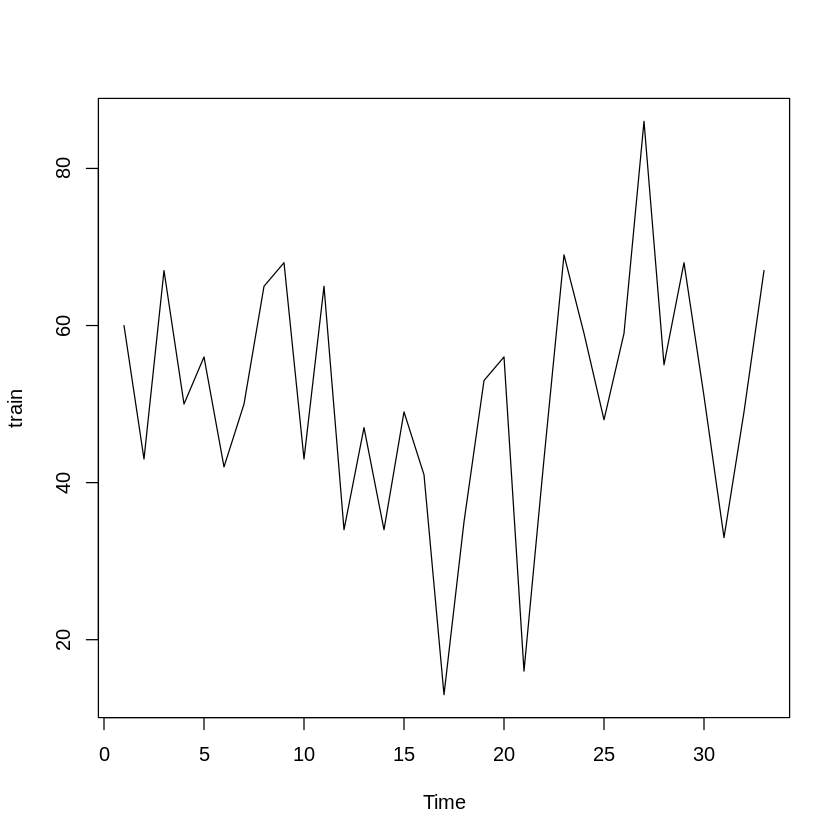

In [31]:
train <- subset(king.ts, end=length(king.ts)-9)  #최근 8년 데이터를 제외한 나머지 데이터를 학습데이터로 선택
test <- subset(king.ts, start=length(king.ts)-8)  #최근 8년 데이터를 테스트 데이터로 선택
plot(train)

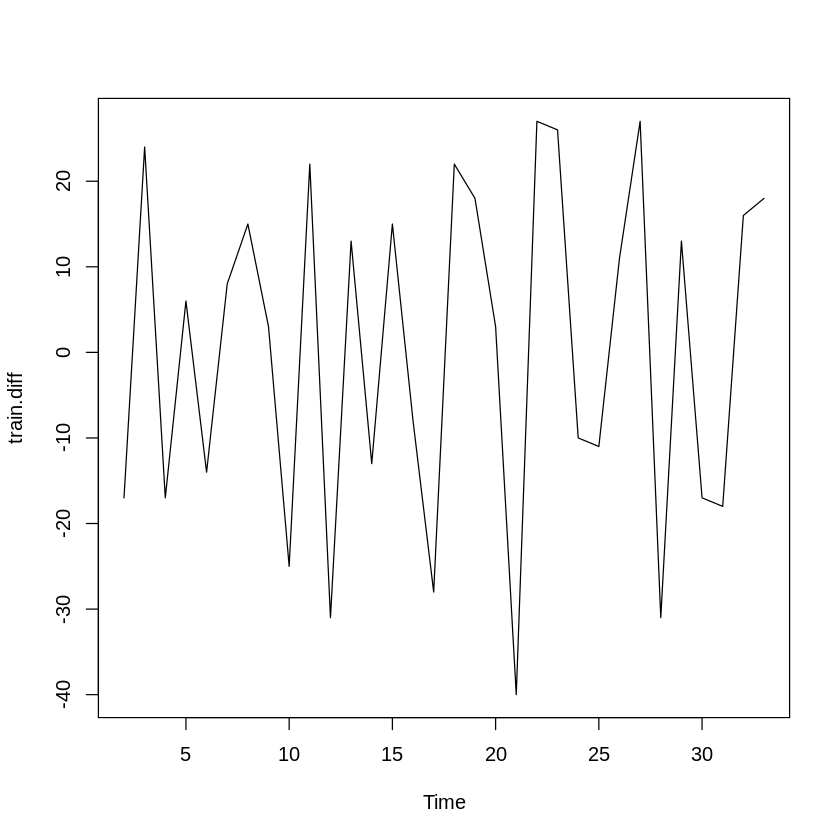

In [32]:
train.diff <- diff(train, differences = 1)
plot(train.diff)

ACF값이 lag 2에서 절단점을 가지므로 MA(1) 모형 => ARIMA(0,1,1) 모델 생성

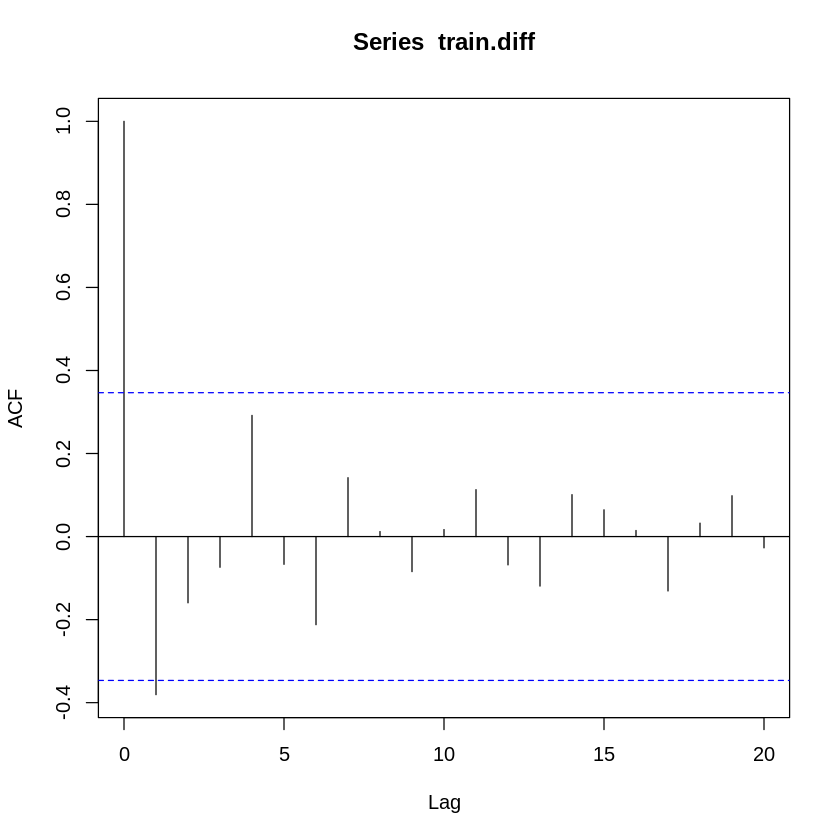

In [34]:
acf(train.diff, lag.max=20)
Fit1 <-  Arima(train, order=c(0,1,1))

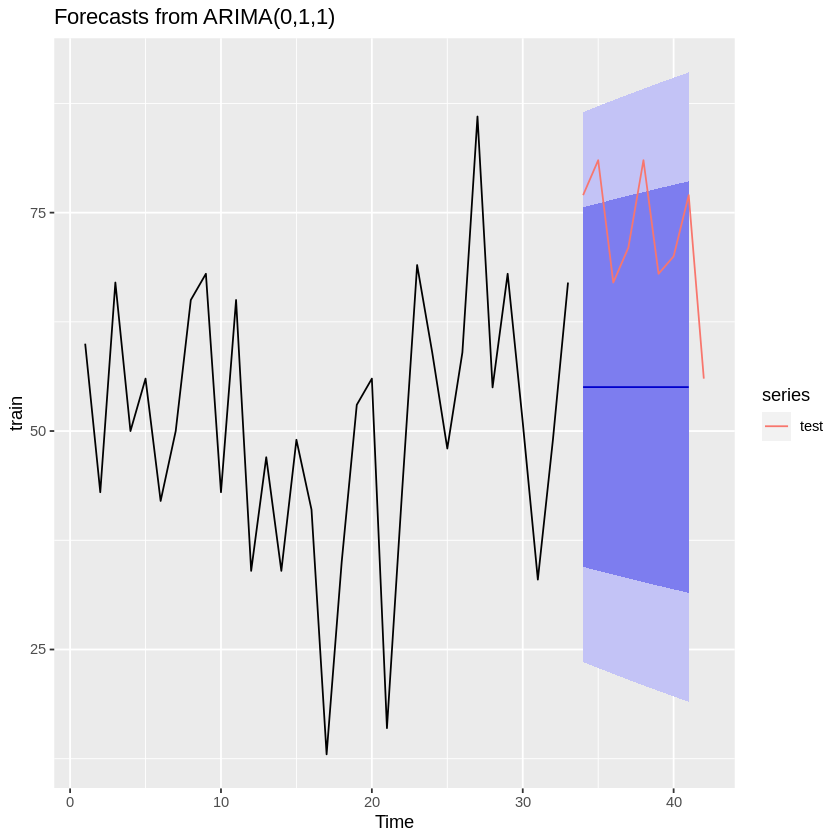

In [36]:
Fit1 %>% forecast(h=8) %>% autoplot() + autolayer(test)
#아래는 영국왕들 사망시 나이의 학습 데이터에 ARIMA(0,1,1) 모델을 사용하여 마지막 8년을 예측한 결과이다.

PACF값이 lag 4에서 절단점을 가지므로 AR(3) 모형 => ARIMA(3,1,0) 모델 생성

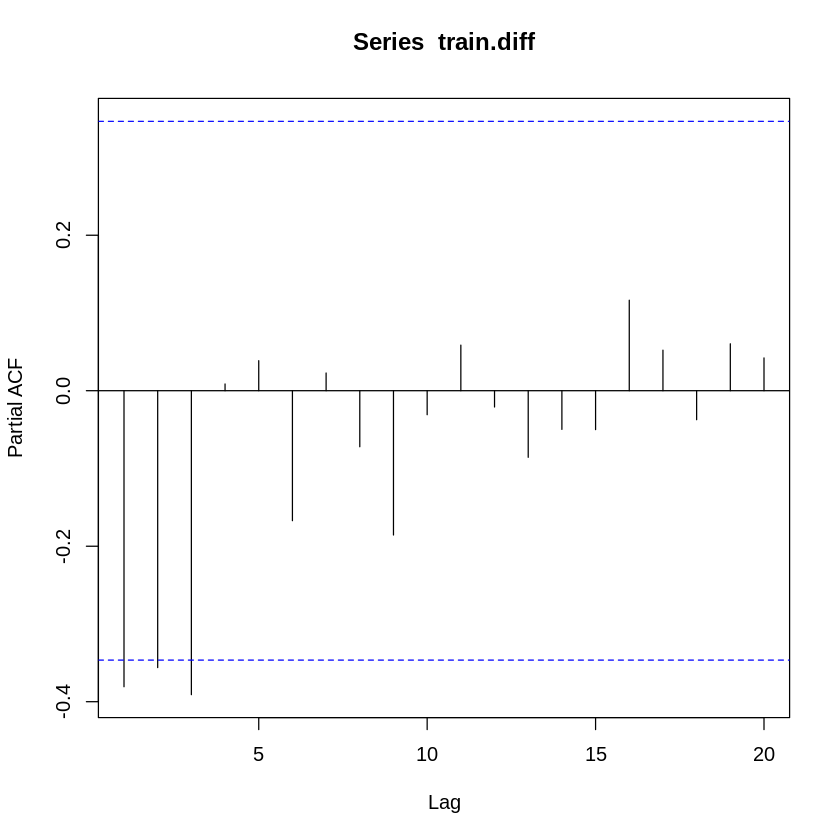

In [38]:
pacf(train.diff, lag.max=20)
Fit2 <- Arima(train, order=c(3,1,0))

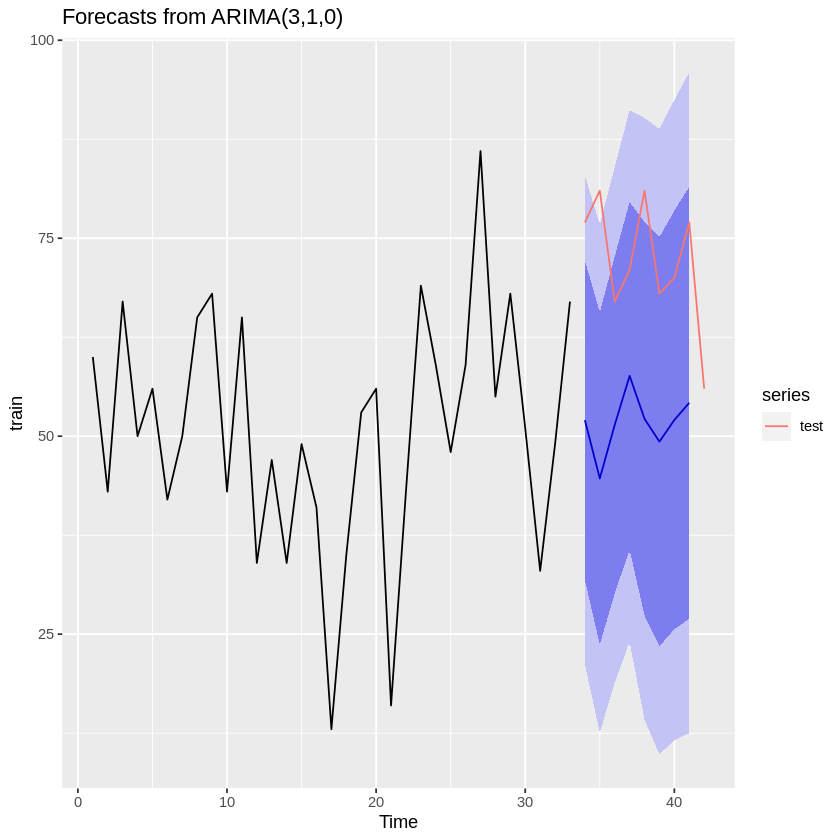

In [39]:
Fit2 %>% forecast(h=8) %>% autoplot() + autolayer(test)
#영국왕들 사망시 나이의 학습 데이터에 ARIMA(3,1,0) 모델을 사용하여 마지막 8년을 예측한 결과이다.

학습 데이터에 auto.arima() 함수를 사용하여 ARIMA(0,0,0) 모델 생성

In [40]:
auto.arima(train)

Series: train 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
         mean
      50.7273
s.e.   2.6318

sigma^2 estimated as 235.7:  log likelihood=-136.45
AIC=276.9   AICc=277.3   BIC=279.89

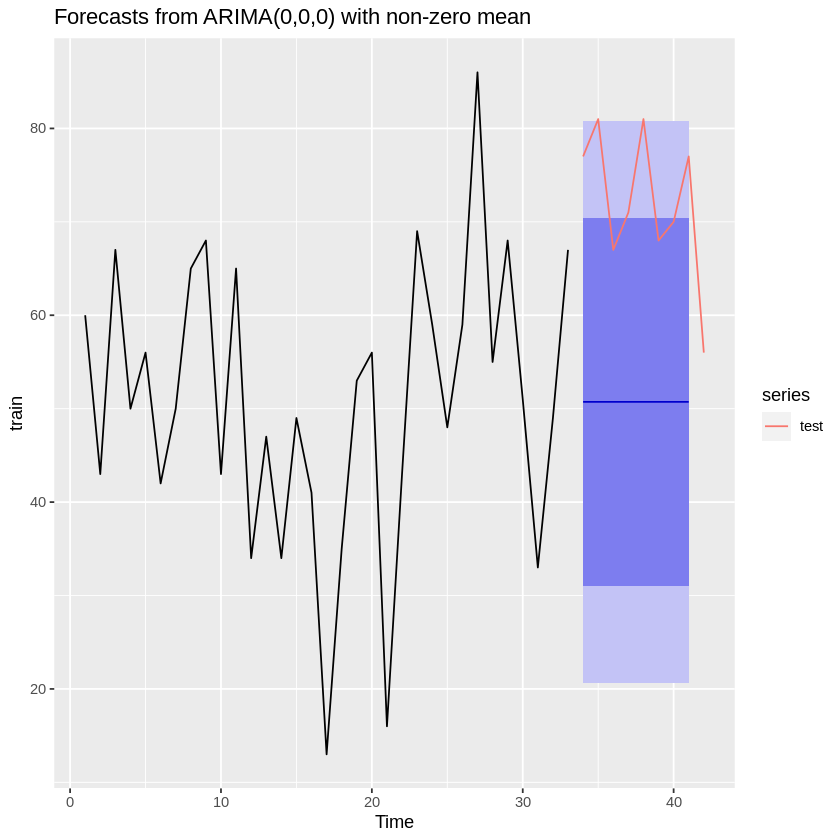

In [41]:
Fit3 <- auto.arima(train)
Fit3 %>% forecast(h=8) %>% autoplot() + autolayer(test)

이전에 얻은 (Fit1,2,3으로 저장된) 모델을 테스트 데이터에 적용한다.

In [42]:
king.test1 <- Arima(test, model=Fit1)
accuracy(king.test1)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-3.172994,8.088363,6.394431,-5.621647,9.65837,0.6820726,-0.3601659


In [43]:
king.test2 <- Arima(test, model=Fit2)
accuracy(king.test2)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-3.07792,8.70433,6.276065,-5.581278,9.625376,0.6694469,-0.3513647


In [44]:
king.test3 <- Arima(test, model=Fit3)
accuracy(king.test3)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,21.27273,22.57521,21.27273,28.68647,28.68647,2.269091,-0.2373541


정확도 값을 분석해보면, 예측 정확도 평가에서 대표적으로 사용되는 RMSE, MAE, MAPE, MASE  모든 오차가 가장 작은ARIMA(0,1,1) 모델이 3가지 모델 중에서 가장 좋다고 할 수 있다.